# 04 · 02  DATA CLEANING  
En esta sección limpiamos y pre-procesamos el conjunto **train.csv** de la competencia *udea-ai-4-eng-20251 Pruebas Saber Pro*.  

## Inspección y análisis de datos faltantes

En esta sección vamos a identificar las columnas que presentan valores faltantes (`NaN`) y exploraremos su distribución y posibles patrones. Esto nos permitirá decidir estrategias adecuadas para su imputación.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from scipy.stats import ttest_ind
from scipy import stats
%matplotlib inline

df = pd.read_csv("train.csv")
print("Shape:", df.shape)
display(df.head())


Shape: (692500, 12)


,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


## Selección de una muestra de datos

Debido al tamaño del dataset original, tomamos una muestra aleatoria de 2,000 registros para trabajar más rápido. Esta muestra será utilizada para las simulaciones y pruebas posteriores.


In [2]:
# Tomar una muestra de 2,000 registros para trabajar más rápido
df = df.sample(n=2000, random_state=42).reset_index(drop=True)
print("Nuevo shape (muestra):", df.shape)
display(df.head())

Nuevo shape (muestra): (2000, 12)


,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,345759,20195,ADMINISTRACION POLICIAL,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Educación profesional completa,No,medio-bajo
1,925052,20195,MEDICINA,RISARALDA,Entre 1 millón y menos de 2.5 millones,0,Estrato 4,Si,Educación profesional completa,Educación profesional completa,Si,alto
2,383355,20212,CONTADURIA PUBLICA,BOGOTÁ,Entre 4 millones y menos de 5.5 millones,Más de 30 horas,Estrato 4,Si,Secundaria (Bachillerato) completa,Primaria completa,Si,medio-bajo
3,70065,20183,LICENCIATURA EN IDIOMAS EXTRANJEROS,ATLANTICO,Entre 500 mil y menos de 1 millón,Entre 21 y 30 horas,Estrato 4,Si,Educación profesional completa,Educación profesional completa,Si,medio-alto
4,8675,20195,LICENCIATURA EN MATEMATICAS,SUCRE,Menos de 500 mil,0,Estrato 1,No,Ninguno,Ninguno,No,medio-bajo


## Revisión de valores faltantes

Revisamos la cantidad de valores faltantes por columna en la muestra seleccionada. Esta información es clave para identificar las columnas que requieren un tratamiento especial, como imputación o codificación.


In [ ]:
# Ver cuántos valores faltantes hay por columna
faltantes = df.isna().sum()
faltantes = faltantes[faltantes != 0]
faltantes


ESTU_VALORMATRICULAUNIVERSIDAD     16
ESTU_HORASSEMANATRABAJA           104
FAMI_ESTRATOVIVIENDA              108
FAMI_TIENEINTERNET                 88
FAMI_EDUCACIONPADRE                72
FAMI_EDUCACIONMADRE                77
ESTU_PAGOMATRICULAPROPIO           16
dtype: int64

### Revisión detallada de la variable `FAMI_ESTRATOVIVIENDA`

Seleccionamos la columna `FAMI_ESTRATOVIVIENDA` para analizar en detalle los valores faltantes y la frecuencia de cada categoría, incluyendo los valores nulos.


In [4]:
col = "FAMI_ESTRATOVIVIENDA"
print("Valores faltantes:", df[col].isna().sum())
df[col].value_counts(dropna=False)


Valores faltantes: 108


FAMI_ESTRATOVIVIENDA
Estrato 2      681
Estrato 3      584
Estrato 1      339
Estrato 4      191
NaN            108
Estrato 5       62
Estrato 6       24
Sin Estrato     11
Name: count, dtype: int64

### Definición de funciones para codificación One-Hot

Creamos dos funciones:

- `to_onehot`: Transforma una lista de valores categóricos en un arreglo One-Hot.
- `replace_column_with_onehot`: Reemplaza una columna categórica en un DataFrame por sus codificaciones One-Hot. Esta función asegura que la columna no tenga valores nulos antes de realizar la transformación.


In [5]:
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)

def replace_column_with_onehot(d, col):
    assert sum(d[col].isna()) == 0, "La columna no debe tener valores faltantes"
    values = np.unique(d[col])
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%s" % (col, values[i]) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r


### Generación de codificaciones One-Hot y filtrado del DataFrame

Creamos dos nuevas versiones codificadas de la variable `FAMI_ESTRATOVIVIENDA`:
- `rm1`: reemplaza los valores faltantes por la categoría "missing".
- `rm2`: reemplaza los valores faltantes por la categoría "Estrato 2".

Luego, filtramos el DataFrame `dn` para conservar únicamente las columnas numéricas y eliminar aquellas con valores faltantes.


In [6]:
rm1 = replace_column_with_onehot(df[[col]].fillna("missing").copy(), col)


In [7]:
rm2 = replace_column_with_onehot(df[[col]].fillna("Estrato 2").copy(), col)


In [8]:
dn = df.T.dropna().T
dn = dn[[i for i in dn.columns if df[i].dtype != object]]


### Unir las codificaciones al DataFrame original

Se crea `dm1` uniendo `dn` con la codificación One-Hot de `FAMI_ESTRATOVIVIENDA` con "missing", y `dm2` uniendo `dn` con la codificación donde los faltantes se reemplazan por "Estrato 2". Finalmente, se muestran las dimensiones de ambos DataFrames.


In [9]:
dm1 = dn.join(rm1)
dm2 = dn.join(rm2)
dm1.shape, dm2.shape


((2000, 10), (2000, 9))

### Transformar la variable de salida a formato numérico

Se asignan valores numéricos a las categorías de `RENDIMIENTO_GLOBAL` para facilitar el análisis. Luego, esta columna transformada (`RENDIMIENTO_GLOBAL_NUM`) se agrega a los DataFrames `dn`, `dm1` y `dm2`.


In [10]:
# Mapear las categorías de RENDIMIENTO_GLOBAL a valores numéricos
rendimiento_map = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
}

df['RENDIMIENTO_GLOBAL_NUM'] = df['RENDIMIENTO_GLOBAL'].map(rendimiento_map)

# Agregar la columna RENDIMIENTO_GLOBAL_NUM a dn, dm1 y dm2
dn['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL_NUM']
dm1['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL_NUM']
dm2['RENDIMIENTO_GLOBAL'] = df['RENDIMIENTO_GLOBAL_NUM']


### Definir funciones auxiliares para los experimentos

A continuación, se definen las funciones necesarias para preparar los datos (`getXY`), ejecutar el experimento con validación cruzada (`experiment`), y realizar las pruebas de hipótesis (`HTest`) usando un `RandomForestRegressor`.


In [11]:
def getXY(dn):
    xcols = [i for i in dn.columns if i != "RENDIMIENTO_GLOBAL"]
    X = dn[xcols].values.astype(float)
    y = dn.RENDIMIENTO_GLOBAL.values.astype(float)
    return X, y, xcols

def experiment(dn, estimator, n_models=20, test_size=0.3):
    X, y, _ = getXY(dn)
    r = cross_val_score(estimator, X, y, cv=ShuffleSplit(n_models, test_size=test_size),
                        scoring=make_scorer(mean_absolute_error))
    return r

def HTest(ref_dataset, h_datasets, n_models=30, experiment=experiment, **kwargs):
    estimator = RandomForestRegressor(n_estimators=20)
    re = [experiment(i, estimator, n_models=n_models, **kwargs) for i in [ref_dataset]+h_datasets]

    for r in re[1:]:
        print(ttest_ind(re[0], r))


### Realizar la prueba de hipótesis con las distintas estrategias de tratamiento de datos

Se ejecuta la función `HTest` para comparar el rendimiento de los modelos entrenados con las distintas versiones del dataset (`dn`, `dm1`, `dm2`), aplicando validación cruzada con 50 iteraciones.


In [12]:
HTest(dn, [dm1, dm2], experiment=experiment, n_models=50)


TtestResult(statistic=np.float64(14.458352578852812), pvalue=np.float64(4.829896520682036e-26), df=np.float64(98.0))
TtestResult(statistic=np.float64(13.659438600520557), pvalue=np.float64(2.035540774950122e-24), df=np.float64(98.0))


### Definir la función `na_experiment` para evaluar el rendimiento del modelo considerando solo los casos con datos faltantes

Se crea una función que permite evaluar el rendimiento del modelo únicamente en los registros con valores originalmente faltantes (según el índice). Esto permite verificar si las diferentes estrategias de tratamiento de valores nulos afectan de manera significativa los resultados en esos casos específicos.


In [13]:
def na_cross_val_score(estimator, X, y, cv, scoring, val_idxs):
    r = []
    for tr_idxs, ts_idxs in cv.split(X):
        tr_idxs, ts_idxs = np.r_[tr_idxs], np.r_[ts_idxs]
        estimator.fit(X[tr_idxs], y[tr_idxs])
        valts_idxs = np.r_[[i for i in ts_idxs if i in val_idxs]]
        r.append(scoring(estimator, X[valts_idxs], y[valts_idxs]))
    return r

def na_experiment(dn, estimator, na_idxs, n_models=20, test_size=.3):
    X, y, _ = getXY(dn)
    r = na_cross_val_score(estimator, X, y, cv=ShuffleSplit(n_models, test_size=test_size),
                           scoring=make_scorer(mean_absolute_error), val_idxs=na_idxs)
    return r


### Evaluar las estrategias de tratamiento de valores faltantes

Utilizamos la función `HTest` con la estrategia `na_experiment` para evaluar el rendimiento del modelo únicamente en las filas donde originalmente había valores faltantes en la columna `FAMI_ESTRATOVIVIENDA`. Esto permite comparar si la imputación con la categoría `missing` o con la categoría más común (`Estrato 2`) tiene un impacto significativo en la calidad del modelo.


In [14]:
na_idxs = np.argwhere(df[col].isna().values)[:,0]
HTest(dn, [dm1, dm2], experiment=na_experiment, na_idxs=na_idxs, n_models=50)


TtestResult(statistic=np.float64(0.9789787856324086), pvalue=np.float64(0.3300010299711986), df=np.float64(98.0))
TtestResult(statistic=np.float64(0.05484332916446795), pvalue=np.float64(0.9563749326478255), df=np.float64(98.0))


### Importancia de las variables después de la imputación con `Estrato 2`

Entrenamos un modelo `RandomForestRegressor` sobre el conjunto de datos `dm2`, que contiene la imputación de valores faltantes en la columna `FAMI_ESTRATOVIVIENDA` usando la categoría más común (`Estrato 2`). Graficamos la importancia de cada variable en el modelo, lo cual nos ayuda a identificar cuáles variables contribuyen más a la predicción del rendimiento global.


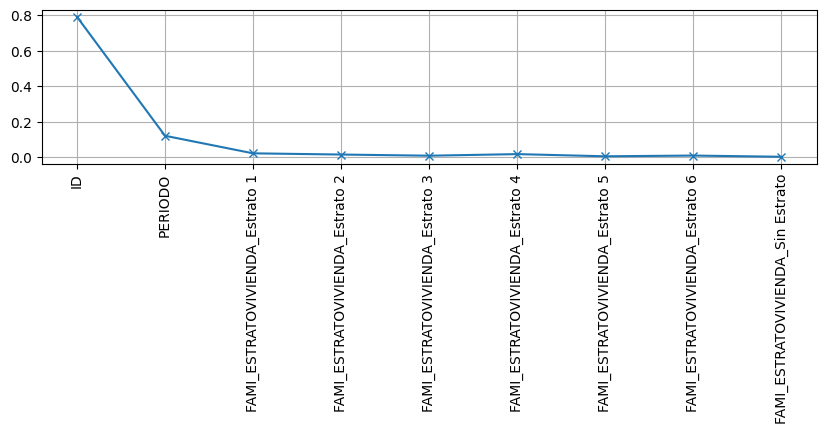

In [15]:
dk = dm2.copy()
X, y, xcols = getXY(dk)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X, y)
plt.figure(figsize=(10,2)); plt.grid()
plt.plot(rf.feature_importances_, label="dm2", marker="x")
plt.xticks(range(len(xcols)), xcols, rotation="vertical")
plt.show()


### Importancia de las variables después de la imputación con la categoría `missing`

Entrenamos un modelo `RandomForestRegressor` sobre el conjunto de datos `dm1`, que contiene la imputación de valores faltantes en la columna `FAMI_ESTRATOVIVIENDA` usando una nueva categoría `missing`. Esto nos permite observar cómo se distribuye la importancia de las variables en el modelo al tratar los datos faltantes como una categoría separada.


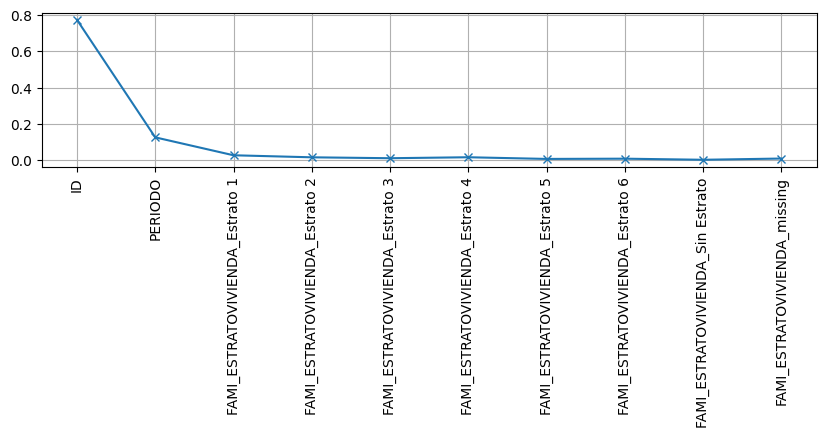

In [16]:
dk = dm1.copy()
X, y, xcols = getXY(dk)
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X, y)
plt.figure(figsize=(10,2)); plt.grid()
plt.plot(rf.feature_importances_, label="dm1", marker="x")
plt.xticks(range(len(xcols)), xcols, rotation="vertical")
plt.show()


### Definición del modelo nulo

Definimos el modelo nulo como una distribución normal para `RENDIMIENTO_GLOBAL`, con media 3.0 y desviación estándar 0.5. Esta elección se basa en el análisis previo de los datos. 

Generamos una simulación de 10,000 valores para visualizar la forma de esta distribución teórica.


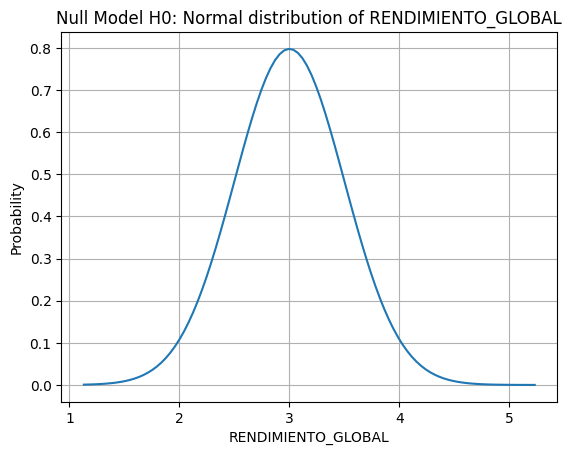

In [17]:
# Defining the null model (adjust based on your previous analysis)
h0 = stats.norm(loc=3.0, scale=0.5)

# Simulating 10,000 values of RENDIMIENTO_GLOBAL according to the null model
x = h0.rvs(10000)
rx = np.linspace(np.min(x), np.max(x), 100)

# Plotting the distribution
plt.plot(rx, h0.pdf(rx))
plt.grid(); plt.xlabel("RENDIMIENTO_GLOBAL"); plt.ylabel("Probability")
plt.title("Null Model H0: Normal distribution of RENDIMIENTO_GLOBAL")
plt.show()


### Simulación de muestras bajo la hipótesis nula

Ahora, vamos a simular 20 muestras de 5 estudiantes cada una, generadas de acuerdo con la distribución del modelo nulo (`Normal(3.0, 0.5)`). Calculamos y mostramos la media de cada muestra, lo cual nos permite entender la variabilidad esperada en el rendimiento global de los estudiantes bajo este modelo.


In [18]:
# Definir el modelo bajo la hipótesis nula
m = stats.norm(loc=3.0, scale=0.5)

# Simular 20 muestras de 5 estudiantes y mostrar la media de cada muestra
for n in range(20):
    s = m.rvs(5)
    print("muestra %2d: " % n + " ".join(["%5.2f" % i for i in s]), " media: %7.2f" % np.mean(s))


muestra  0:  2.42  2.83  2.30  2.87  2.42  media:    2.57
muestra  1:  2.45  3.45  3.25  3.10  3.01  media:    3.05
muestra  2:  3.70  3.17  3.33  2.33  3.19  media:    3.15
muestra  3:  3.32  3.40  3.67  2.83  2.63  media:    3.17
muestra  4:  2.99  2.83  3.04  3.20  3.79  media:    3.17
muestra  5:  2.83  2.48  2.39  3.41  2.29  media:    2.68
muestra  6:  3.30  4.15  1.30  3.74  3.21  media:    3.14
muestra  7:  2.99  3.26  3.52  3.30  2.28  media:    3.07
muestra  8:  2.93  2.91  2.61  3.65  2.70  media:    2.96
muestra  9:  2.50  3.57  3.06  2.89  2.51  media:    2.91
muestra 10:  2.68  2.10  3.77  2.46  2.56  media:    2.71
muestra 11:  3.73  3.16  2.19  2.63  3.94  media:    3.13
muestra 12:  3.66  3.12  2.91  2.97  2.61  media:    3.05
muestra 13:  2.66  3.31  2.56  4.03  3.24  media:    3.16
muestra 14:  3.54  3.22  2.90  2.83  2.90  media:    3.08
muestra 15:  3.83  2.48  2.54  2.81  2.44  media:    2.82
muestra 16:  2.60  3.48  3.46  3.06  2.68  media:    3.06
muestra 17:  3

### Distribución de muestreo bajo la hipótesis nula

Simulamos 10,000 medias de muestras de 5 estudiantes, generadas bajo la hipótesis nula (media = 3.0, desviación estándar = 0.5). Esta distribución de muestreo nos permite evaluar la probabilidad de obtener diferentes medias muestrales bajo el supuesto de que la hipótesis nula es verdadera.


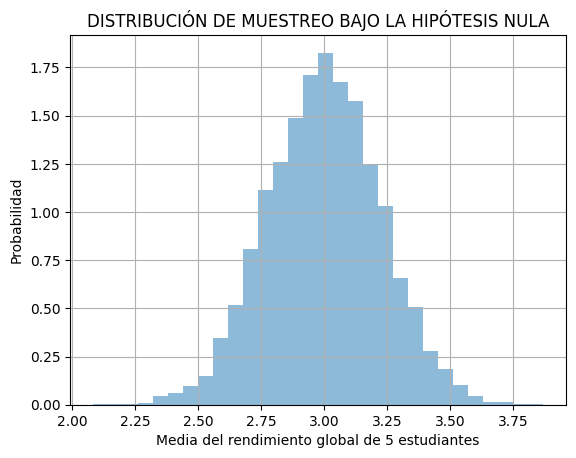

In [19]:
# Simulación de 10,000 medias de muestras de 5 estudiantes bajo la hipótesis nula
z = np.r_[[np.mean(m.rvs(5)) for _ in range(10000)]]

# Graficar la distribución de muestreo
plt.hist(z, bins=30, density=True, alpha=0.5)
plt.grid()
plt.xlabel("Media del rendimiento global de 5 estudiantes")
plt.ylabel("Probabilidad")
plt.title("DISTRIBUCIÓN DE MUESTREO BAJO LA HIPÓTESIS NULA")
plt.show()


### Evaluar la rareza de nuestras muestras reales

Ahora, comparamos la distribución simulada de medias de 5 estudiantes bajo la hipótesis nula con las medias reales observadas (en este caso, 3.5 y 3.3). El objetivo es visualizar qué tan probable es obtener estos valores si la hipótesis nula fuera verdadera. Si los valores observados se encuentran en las colas de la distribución, la hipótesis nula podría ser cuestionada.


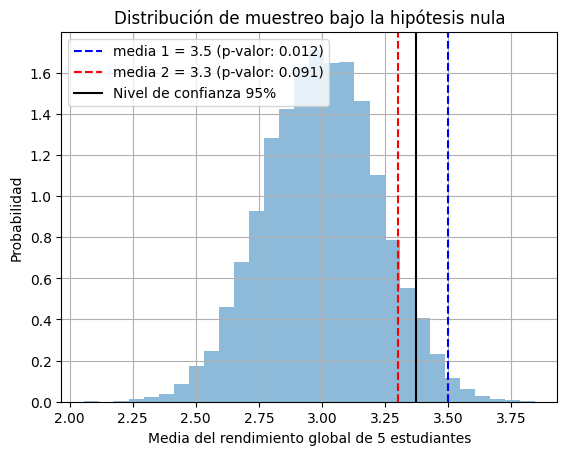

In [20]:
# Definimos la distribución simulada de medias de 5 estudiantes
z = np.r_[[np.mean(m.rvs(5)) for _ in range(10000)]]

# Definimos las medias de nuestras muestras reales
# Cambia estos valores por los de tu caso real
sample1 = 3.5
sample2 = 3.3

# Graficamos la distribución con las líneas de referencia
plt.hist(z, bins=30, density=True, alpha=.5);
plt.axvline(sample1, color="blue", ls="--", label=f"media 1 = {sample1} (p-valor: {np.mean(z>sample1):.3f})")
plt.axvline(sample2, color="red", ls="--", label=f"media 2 = {sample2} (p-valor: {np.mean(z>sample2):.3f})")
plt.axvline(np.percentile(z, 95), color="black", label="Nivel de confianza 95%")
plt.grid()
plt.xlabel("Media del rendimiento global de 5 estudiantes")
plt.ylabel("Probabilidad")
plt.legend()
plt.title("Distribución de muestreo bajo la hipótesis nula")
plt.show()


### Simulación para 30 estudiantes

Realizamos la simulación de 10,000 medias de muestras de 30 estudiantes bajo la hipótesis nula. Esto nos permite analizar cómo cambia la distribución de las medias cuando aumenta el tamaño de muestra, y si la media observada (3.3) sigue siendo compatible con la hipótesis nula. Visualizamos la media observada sobre la distribución simulada.


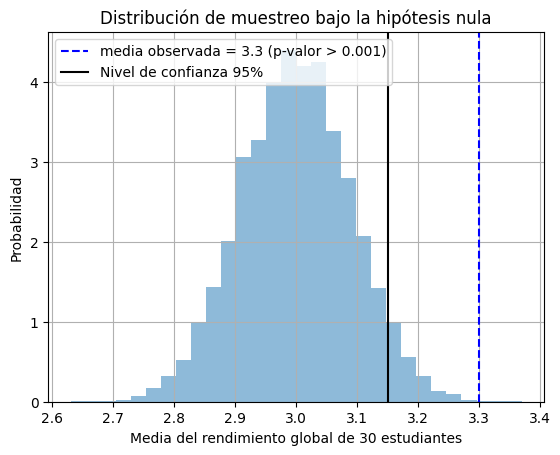

In [21]:
# Simulamos 10,000 medias de muestras de 30 estudiantes bajo la hipótesis nula
z = np.r_[[np.mean(m.rvs(30)) for _ in range(10000)]]

# Graficamos la distribución de muestreo
plt.hist(z, bins=30, density=True, alpha=.5);
plt.axvline(3.3, color="blue", ls="--", label="media observada = 3.3 (p-valor > %.3f)" % np.mean(z > 3.3))
plt.axvline(np.percentile(z, 95), color="black", label="Nivel de confianza 95%")
plt.grid(); plt.xlabel("Media del rendimiento global de 30 estudiantes"); plt.ylabel("Probabilidad")
plt.legend(); plt.title("Distribución de muestreo bajo la hipótesis nula"); plt.show()


### Comparación de distribuciones de muestreo para diferentes tamaños de muestra

A continuación, comparamos las distribuciones de muestreo para diferentes tamaños de muestra: 5, 30 y 100 estudiantes. Esto nos permite ver cómo cambia la variabilidad y la concentración de las medias cuando usamos distintos tamaños de muestra. A medida que el tamaño de la muestra aumenta, la distribución se vuelve más estrecha, reflejando una menor variabilidad en las medias.


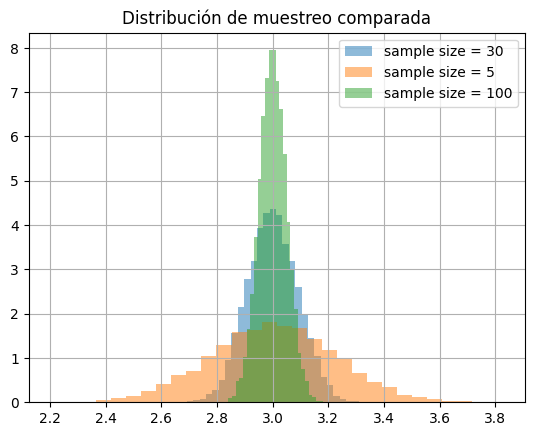

In [22]:
z1 = np.r_[[np.mean(m.rvs(30)) for _ in range(10000)]]
z2 = np.r_[[np.mean(m.rvs(5)) for _ in range(10000)]]
z3 = np.r_[[np.mean(m.rvs(100)) for _ in range(10000)]]

plt.hist(z1, bins=30, density=True, alpha=.5, label="sample size = 30")
plt.hist(z2, bins=30, density=True, alpha=.5, label="sample size = 5")
plt.hist(z3, bins=30, density=True, alpha=.5, label="sample size = 100")
plt.grid(); plt.legend(); plt.title("Distribución de muestreo comparada"); plt.show()


### Definición de grupos para comparación

Para evaluar si hay una diferencia significativa en los puntajes de rendimiento global de los estudiantes, generamos dos grupos simulados bajo la suposición de un pequeño cambio de media (diferencia de medias de 0.3). Este proceso nos permitirá realizar las pruebas de hipótesis más adelante.


In [23]:
# Parámetros para tu caso (rendimiento global de estudiantes)
real_world_sample_size = 10
mu, sigma = 3.0, 0.5  # Media y desviación estándar estimadas a partir de tu dataset

def generate_AB(mu=mu, sigma=sigma, real_world_sample_size=real_world_sample_size, mean_diff=0.3):
    A = np.random.normal(loc=mu, scale=sigma, size=real_world_sample_size)
    B = np.random.normal(loc=mu + mean_diff, scale=sigma, size=real_world_sample_size)
    return A, B

# Generar un ejemplo
A, B = generate_AB()

print("Grupo A  [", " ".join(["%5.2f" % i for i in A]), "]  media %5.2f" % np.mean(A))
print("Grupo B  [", " ".join(["%5.2f" % i for i in B]), "]  media %5.2f" % np.mean(B))


Grupo A  [  2.92  3.03  2.60  3.13  3.26  2.57  2.24  3.07  3.46  2.76 ]  media  2.90
Grupo B  [  4.18  3.86  4.08  4.01  3.34  4.25  3.44  2.77  3.12  2.77 ]  media  3.58


### Simulación de la distribución del estadístico t bajo la hipótesis nula

Ahora, vamos a simular la distribución del estadístico t para comparar las medias de dos grupos de estudiantes, bajo la hipótesis nula de que **no hay diferencia significativa entre las medias**. 

Generamos 3000 pares de muestras de tamaño 10, calculamos el estadístico t para cada par y graficamos la distribución. Las líneas negras representan los límites del 95% de confianza para la diferencia de medias estandarizada.


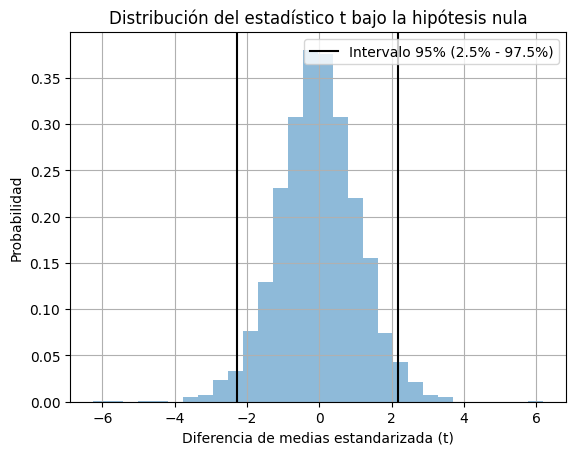

In [27]:
# Definición de la función t-test (diferencia de medias estandarizada)
ttest = lambda a, b: (np.mean(a) - np.mean(b)) / np.sqrt(np.std(a)**2/len(a) + np.std(b)**2/len(b))

# Parámetros
n = 3000
mu, sigma = 3.0, 0.5
real_world_sample_size = 10

# Simulaciones
a = np.concatenate([stats.norm(loc=mu, scale=sigma).rvs(real_world_sample_size)[np.newaxis, :] for _ in range(n)])
b = np.concatenate([stats.norm(loc=mu, scale=sigma).rvs(real_world_sample_size)[np.newaxis, :] for _ in range(n)])

# Estadístico t
t = np.r_[[ttest(i,j) for i,j in zip(a,b)]]

# Graficar
plt.hist(t, density=True, alpha=0.5, bins=30)
plt.axvline(np.percentile(t, 2.5), color="black", label="Intervalo 95% (2.5% - 97.5%)")
plt.axvline(np.percentile(t, 97.5), color="black")
plt.grid()
plt.legend()
plt.xlabel("Diferencia de medias estandarizada (t)")
plt.ylabel("Probabilidad")
plt.title("Distribución del estadístico t bajo la hipótesis nula")
plt.show()


### Comparación de nuestro estadístico t real con la distribución simulada

A continuación, tomamos las muestras reales generadas previamente para los grupos A y B. Calculamos el estadístico t observado para estas muestras y lo comparamos con la distribución de t obtenida por simulación. Esto nos permite evaluar cuán probable es nuestro resultado real bajo la hipótesis nula.


Grupo A  [  2.92  3.03  2.60  3.13  3.26  2.57  2.24  3.07  3.46  2.76 ]  media  2.90
Grupo B  [  4.18  3.86  4.08  4.01  3.34  4.25  3.44  2.77  3.12  2.77 ]  media  3.58


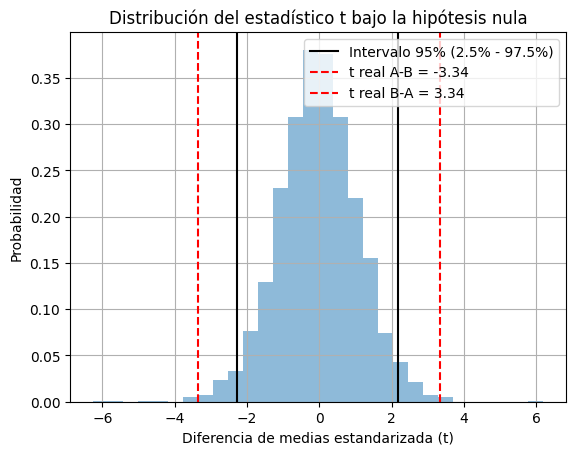

In [28]:
# Reutilizamos A y B generados previamente
print("Grupo A  [", " ".join(["%5.2f" % i for i in A]), "]  media %5.2f" % np.mean(A))
print("Grupo B  [", " ".join(["%5.2f" % i for i in B]), "]  media %5.2f" % np.mean(B))

# Gráfico de la distribución del estadístico t y nuestro t real
plt.hist(t, density=True, alpha=0.5, bins=30)
plt.axvline(np.percentile(t, 2.5), color="black", label="Intervalo 95% (2.5% - 97.5%)")
plt.axvline(np.percentile(t, 97.5), color="black")
plt.axvline(ttest(A,B), color="red", ls="--", label="t real A-B = %.2f" % ttest(A,B))
plt.axvline(ttest(B,A), color="red", ls="--", label="t real B-A = %.2f" % ttest(B,A))
plt.grid()
plt.legend()
plt.xlabel("Diferencia de medias estandarizada (t)")
plt.ylabel("Probabilidad")
plt.title("Distribución del estadístico t bajo la hipótesis nula")
plt.show()


### Cálculo del p-valor empírico

Calculamos el p-valor empírico comparando nuestro estadístico t real con la distribución de t generada por simulación. Esto nos indica la probabilidad de obtener un valor tan extremo como el nuestro bajo la hipótesis nula.


In [29]:
# Calcular el p-valor empírico simulando
k = np.mean(ttest(A, B) < t)
k = (k if k < 0.5 else 1 - k) * 2
print("p-valor empírico (simulado): %.4f" % k)


p-valor empírico (simulado): 0.0073


### Cálculo del p-valor analítico

Usamos la función `ttest_ind` de `scipy.stats` para obtener el p-valor exacto mediante la fórmula analítica del t-test de dos muestras independientes.


In [30]:
# Calcular p-valor con fórmula analítica
pval_analitico = stats.ttest_ind(A, B).pvalue
print("p-valor analítico:", pval_analitico)


p-valor analítico: 0.005309464168732783


### Validación de la precisión de simulaciones

A continuación, implementamos una función para comparar la precisión de las simulaciones (p-valores empíricos) con los p-valores calculados analíticamente mediante la fórmula de t-test de dos muestras independientes. Evaluamos cómo cambia el error promedio entre ambos enfoques dependiendo del tamaño de la simulación.

La función realiza los siguientes pasos:
- Genera `n` pares de muestras simuladas bajo la hipótesis nula.
- Calcula el estadístico `t` para cada par.
- Calcula p-valores empíricos y analíticos para 1000 pares adicionales.
- Muestra la relación en un gráfico de dispersión y reporta errores promedio.


In [31]:
def test_simulations(n, mu=mu, sigma=sigma, real_world_sample_size=real_world_sample_size):
    # Generamos 3000 pares de muestras de tamaño 'real_world_sample_size' bajo la hipótesis nula
    a = np.array([stats.norm(loc=mu, scale=sigma).rvs(real_world_sample_size) for _ in range(n)])
    b = np.array([stats.norm(loc=mu, scale=sigma).rvs(real_world_sample_size) for _ in range(n)])

    # Calculamos el estadístico t para cada par
    t = np.array([ttest(A, B) for A, B in zip(a, b)])

    # Evaluamos 1000 veces la diferencia de medias
    r = []
    for _ in range(1000):
        A, B = generate_AB(mu=mu, sigma=sigma, real_world_sample_size=real_world_sample_size)
        ts = ttest(A, B)
        k = np.mean(ts < t)
        k = (k if k < 0.5 else 1 - k) * 2
        r.append([k, stats.ttest_ind(A, B).pvalue])
    r = np.array(r)

    # Graficamos la relación entre p-valor empírico y analítico
    plt.scatter(r[:, 0], r[:, 1], s=2)
    plt.grid(); plt.xlabel("p-valor empírico"); plt.ylabel("p-valor analítico")
    plt.title(f"Relación entre p-valor simulado y analítico (n={n})")
    
    em, an = r[:, 0], r[:, 1]
    print("Error promedio (simulado/analítico): %.3f" % np.mean(np.abs(em - an)))
    print("Error promedio para p-valor < 0.05: %.3f" % np.mean(np.abs(em[an < 0.05] - an[an < 0.05])))

### Evaluación de la precisión de p-valores según el tamaño de la simulación

Realizamos una serie de simulaciones para comparar los p-valores empíricos (calculados mediante Monte Carlo) con los p-valores analíticos (calculados mediante fórmulas estadísticas).  
Probamos con diferentes tamaños de simulación (`n=100`, `n=1000` y `n=6000`) para analizar cómo influye el tamaño de la simulación en la precisión y consistencia de los resultados.  
Esperamos que a mayor tamaño de simulación, la precisión de los p-valores empíricos mejore y se acerque más a los resultados analíticos.


Error promedio (simulado/analítico): 0.058
Error promedio para p-valor < 0.05: 0.007


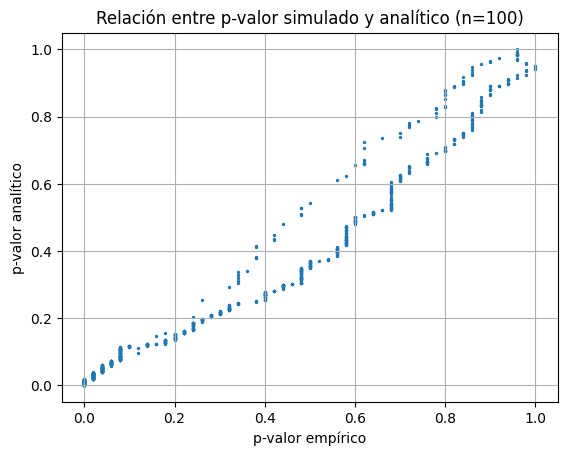

In [33]:
# Probar con diferentes tamaños de simulación
test_simulations(n=100)


Error promedio (simulado/analítico): 0.008
Error promedio para p-valor < 0.05: 0.003


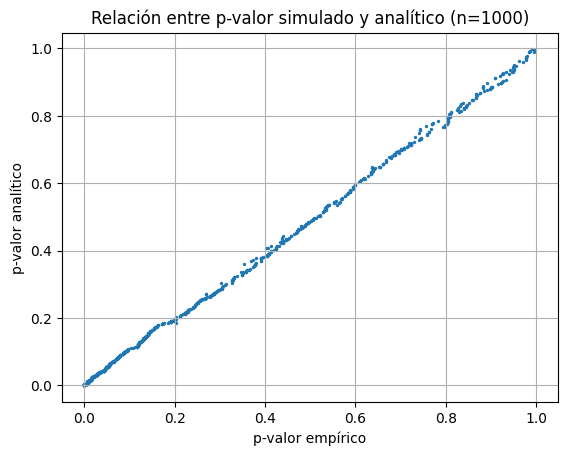

In [34]:
test_simulations(n=1000)


Error promedio (simulado/analítico): 0.005
Error promedio para p-valor < 0.05: 0.003


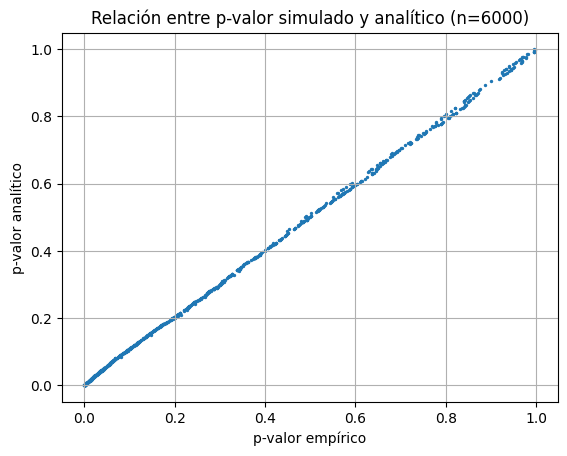

In [ ]:
test_simulations(n=6000)